# COMP9444 Project: Sentiment Analysis

## Introduction

Sentiment analysis, a fundamental task in Natural Language Processing (NLP), involves the classification of text into positive, negative, or neutral sentiments. The ability to accurately gauge sentiment from textual data has gained immense importance in numerous domains, ranging from customer feedback analysis to stock market prediction.

## Motivation

The motivation behind this project stems from the need to understand the effectiveness of various methods in different contexts. As sentiment analysis plays a vital role across different industries, it is crucial to explore and compare diverse approaches to identify the most suitable techniques for specific applications.

Traditional machine learning methods like SVM have been widely used for sentiment analysis, while deep learning models such as BiLSTM and CNN-LSTM have demonstrated remarkable success in various NLP tasks. However, their performance in sentiment analysis tasks and their adaptability to different datasets are yet to be thoroughly examined and compared.

## Problem Statement

The main problem addressed in this project is to determine the most effective sentiment analysis approach between SVM, BiLSTM, and CNN-LSTM for the given binary and triple class sentiment datasets. By conducting a detailed evaluation, we seek to identify which method yields superior results in accurately classifying sentiments expressed in threads app review and twitter posts related to the US airline industry.

The project's findings will provide valuable insights into the performance and suitability of these techniques in specific sentiment analysis scenarios. These insights can guide future research in choosing appropriate sentiment analysis methods based on dataset characteristics and application requirements.

## Data Sources and Tasks

Specifically, we focus on evaluating Support Vector Machine (SVM) as a representative machine learning method, and Bidirectional Long Short-Term Memory (BiLSTM) and Convolutional Neural Network with Long Short-Term Memory (CNN-LSTM) as representative deep learning methods. The comparison is carried out on two distinct datasets: a binary classification task using [threads app reviews](https://www.kaggle.com/datasets/saloni1712/threads-an-instagram-app-reviews) and a tri-class classification task using [US airline sentiment data](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).

The Threads app reviews dataset presents binary classification problem. The goal is to predict whether a particular review expresses satisfaction or dissatisfaction with the Threads app, a popular social messaging platform. By accurately analyzing user sentiments, the Threads app team can make data-driven decisions to enhance user experiences, address concerns, and optimize the app's functionalities to meet the needs of its users effectively.

The US airline sentiment dataset offers a more complex sentiment analysis task, encompassing three sentiment classes: positive, negative and neutral. Sentiment analysis on this dataset can be essential for US airlines to monitor customer satisfaction, identify areas of improvement in their services, and respond promptly to customer feedback.

## Import Dependencies and Configure GPU Settings

In [1]:
import drive as drive
import numpy as np
import pandas as pd
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from gensim.models import Word2Vec

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
drive.mount('/content/drive')

cpu


AttributeError: module 'drive' has no attribute 'mount'

Check if a CUDA device (i.e., GPU) exists that can be used, and if it does then the device (device) is set to a CUDA device, and if it doesn't then the device is set to a CPU.This is mainly because the PyTorch library can be run on a CUDA device and computations running on a CUDA device are usually much faster than running on a CPU, especially when working with large-scale data and models.

Here torch.device() is the function used to move the tensor to the device, while torch.cuda.is_available() checks if there is an available CUDA device. When a CUDA device (typically a GPU) exists, the device is set to 'cuda', otherwise 'cpu'.

## Exploratory Analysis and Preprocessing



In [2]:
def clean_train_data(x):
    text = str(x)  # ensure x is str
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\n', '', text)
    return text

This function is appied to clean and normalize the text data in the training dataset, ensuring that the subsequent sentiment analysis model can better comprehend and learn from the text. Specific steps involved in the preprocessing are as follows:

Lowercasing (`text.lower()`): By converting all text to lowercase, discrepancies due to varying letter cases are removed. This step ensures that models treat words with different cases as the same, avoiding redundancy and improving the overall understanding of the words' meanings.

Removing Extra Spaces (`re.sub(r'\s+', ' ', text)`): Multiple consecutive spaces are replaced with a single space. This process compacts the text, making the format consistent for subsequent analysis.

Removing Square Brackets and Contents (`re.sub('\[. *? \]', '', text)`): Square brackets and contents within are removed using a regex substitution. These brackets might contain non-essential or noisy information, and eliminating them helps to focus on the core content of the text.

Removing Punctuation (`re.sub(r'[^\w\s]', '', text)`): All punctuation marks are removed, while retaining words and spaces using a regex. Punctuation often does not contribute significantly to sentiment analysis and can be safely disregarded.

Removing Words with Numbers (`re.sub('\w*\d\w*', '', text)`): Words containing numbers are removed from the text. Numbers in many natural language processing tasks may not provide relevant information and can be omitted to reduce unnecessary complexity in the model's input data.

Removing Line Breaks (`re.sub('\n', '', text)`): Line breaks, which have no inherent meaning in the text, are removed. This action ensures that the text is seamlessly processed and avoids any misinterpretation due to the presence of line breaks.

Overall, this preprocessing function plays a vital role in enhancing the quality and consistency of the text data, as it lays the foundation for effective feature extraction and enables the model to better understand the sentiment.

 ### Threads App Review Dataset (binary)

In [3]:
data = pd.read_csv("../data/threads1.csv")
data.shape

data['review'] = data.review.apply(lambda x : clean_train_data(x))
data = data[data['sentiment'] != 'neutral']

The code filters out all rows from the data frame where the "Sentiment" value is "neutral." This step is taken to focus solely on the positive and negative sentiments, disregarding neutral sentiments, which are not relevant at this stage.

### US Airline Comment Dataset (triple)

In [3]:
data = pd.read_csv("../data/Tweets.csv")
data.shape

data = data[data['airline_sentiment_confidence'] > 0.5]
data.shape

class_count = data['airline_sentiment'].value_counts()
class0_count = class_count[0]
class1_count = class_count[1]
class2_count = class_count[2]

max_count = max(class0_count, class1_count, class2_count)
diff_class1 = max_count - class1_count
diff_class2 = max_count - class2_count

class1_samples = resample(data[data['airline_sentiment'] == 'neutral'],
                n_samples=diff_class1, replace=True, random_state=42)

class2_samples = resample(data[data['airline_sentiment'] == 'positive'],
                n_samples=diff_class2, replace=True, random_state=42)

data = pd.concat([data,class1_samples, class2_samples])

The code applies selective filtering to retain only high-confidence sentiment tweets, as determined by a confidence level greater than 0.5 in the 'airline_sentiment_confidence' column. It then performs class balancing to ensure equal representation of sentiment categories (positive, negative, and neutral) by oversampling categories with fewer samples.

To achieve this, the code first calculates the number of samples for each sentiment category and identifies the maximum sample count among them. Then it determines the differences between the maximum count and the counts of 'neutral' and 'positive' categories, saving these calculations as 'diff_class1' and 'diff_class2', respectively.

Using the 'resample' function, the code generates additional samples for 'neutral' and 'positive' categories through repeated sampling, bringing their sample counts to match the maximum count. This equalizes the number of samples across all categories, mitigating bias towards categories with higher samples during model training.

Finally, the code merges the original data with the added samples to create a new balanced DataFrame using the `pd.concat` function.

Overall, the code ensures that the sentiment analysis model is trained on a balanced dataset, addressing class imbalance issues. The technique of oversampling allows the model to learn effectively from all sentiment categories, preventing biases towards categories with more samples.

## Machine Learning Methods


### Binary Classification

#### SVM

In [28]:
# TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english', max_features=10000)
X = tfidf.fit_transform(data['review'])
y = data['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm = LinearSVC(random_state=42)


svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)


print('Accuracy:', accuracy_score(y_test, y_pred))


print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


print('Classification Report:\n', classification_report(y_test, y_pred))

def clean_input_data(x):
    text = x.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\n', '', text)
    return text

def predict_sentiment(sentence, tfidf_vectorizer, svm_model):
    cleaned_sentence = clean_input_data(sentence)
    vectorized_sentence = tfidf_vectorizer.transform([cleaned_sentence])
    prediction = svm_model.predict(vectorized_sentence)
    return prediction[0]


input_sentence_positive = "I am very happy with this restaurant!"
predicted_sentiment_positive = predict_sentiment(input_sentence_positive, tfidf, svm)


input_sentence_negative = "It's so terrible to learn that the plant was late."

predicted_sentiment_negative = predict_sentiment(input_sentence_negative, tfidf, svm)

print(input_sentence_positive)
print("Predicted Sentiment positive:", predicted_sentiment_positive)
print(input_sentence_negative)
print("Predicted Sentiment negative:", predicted_sentiment_negative)

Accuracy: 0.8258333333333333
Confusion Matrix:
 [[453 133]
 [ 76 538]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.77      0.81       586
    positive       0.80      0.88      0.84       614

    accuracy                           0.83      1200
   macro avg       0.83      0.82      0.82      1200
weighted avg       0.83      0.83      0.83      1200

I am very happy with this restaurant!
Predicted Sentiment positive: positive
It's so terrible to learn that the plant was late.
Predicted Sentiment negative: negative


D:\python\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Accuracy: 0.8491666666666666\
Confusion Matrix:
$$\begin{matrix}
539&94\\
87&480\\
\end{matrix}$$
Classification Report:

               precision    recall     f1-score    support

     negative       0.86      0.85      0.86      633
     positive       0.84      0.85      0.84      567

     accuracy                       0.85      1200
     macro avg      0.85      0.85      0.85      1200
     weighted avg     0.85      0.85     0.85       1200


 Process finished with exit code 0

Model training is done using LinearSVC (Linear Support Vector Classifier). fit function is used to train the model and predict function is used to predict the results of the test set. Based on the output, the accuracy of the model is 0.85, which means that the probability of the model predicting correctly is 85%. The confusion matrix shows the performance of the model on each category. Whereas the classification report shows the details of precision, recall and F1 score for each category.

Overall, we have implemented a fairly accurate sentiment classifier using TF-IDF and SVM, which is able to identify both positive and negative sentiment of comments better.


### Tri-class Classification

#### SVM

In [16]:
# Utilizing TF-IDF to vectorize text data
tfidf = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english', max_features=10000)
X = tfidf.fit_transform(data['text'])
y = data['airline_sentiment']

# Divide into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM
svm = LinearSVC(random_state=42)

# Train model
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Get score, matrix and report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.8043032786885246
Confusion Matrix:
 [[1735  116   38]
 [ 224  304   52]
 [  92   51  316]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.92      0.88      1889
     neutral       0.65      0.52      0.58       580
    positive       0.78      0.69      0.73       459

    accuracy                           0.80      2928
   macro avg       0.76      0.71      0.73      2928
weighted avg       0.80      0.80      0.80      2928



D:\python\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.8043032786885246\
Confusion Matrix:
$$\begin{matrix}
1735&116&38\\
224&304&52\\
92&51&316\\
\end{matrix}$$
 Classification Report:

                precision    recall  f1-score   support

     negative       0.85      0.92      0.88      1889
      neutral       0.65      0.52      0.58       580
     positive       0.78      0.69      0.73       459

     accuracy                           0.80      2928
    macro avg       0.76      0.71      0.73      2928
    weighted avg       0.80      0.80      0.80      2928

 Process finished with exit code 0

The code is the same code that classifies textual sentiment, but unlike the previous case, this time there are three categories of classification labels: negative, neutral and positive.

The results obtained by running the code show that the overall accuracy of the model is 0.8043.

We can see that this model performs best in predicting negative comments, with higher precision, recall, and F1 scores; while it performs poorly in predicting neutral comments, which may be due to the sample imbalance (the sample size of negative comments is much larger than that of neutral and positive comments).

## Deep Learning Methods

### Binary Classification

#### BiLSTM without cross validation

Epoch 1/50
150/150 - 72s - loss: 0.5599 - accuracy: 0.7044 - val_loss: 0.3982 - val_accuracy: 0.8375 - 72s/epoch - 482ms/step
Epoch 2/50


D:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 69s - loss: 0.3326 - accuracy: 0.8687 - val_loss: 0.3285 - val_accuracy: 0.8842 - 69s/epoch - 459ms/step
Epoch 3/50
150/150 - 69s - loss: 0.2720 - accuracy: 0.8988 - val_loss: 0.3460 - val_accuracy: 0.8617 - 69s/epoch - 459ms/step
Epoch 4/50
150/150 - 69s - loss: 0.2322 - accuracy: 0.9104 - val_loss: 0.3607 - val_accuracy: 0.8600 - 69s/epoch - 461ms/step
Epoch 5/50
150/150 - 70s - loss: 0.1988 - accuracy: 0.9281 - val_loss: 0.3969 - val_accuracy: 0.8600 - 70s/epoch - 465ms/step
38/38 - 3s - loss: 0.3969 - accuracy: 0.8600 - 3s/epoch - 78ms/step
38/38 [==============================] - 3s 72ms/step
Average score: 0.3968947231769562
Average accuracy: 0.8600000143051147
Confusion Matrix (Fold 1):
[[529 104]
 [ 64 503]]

Classification Report (Fold 1):
              precision    recall  f1-score   support

    negative       0.89      0.84      0.86       633
    positive       0.83      0.89      0.86       567

    accuracy                           0.86      1200
   macro avg 

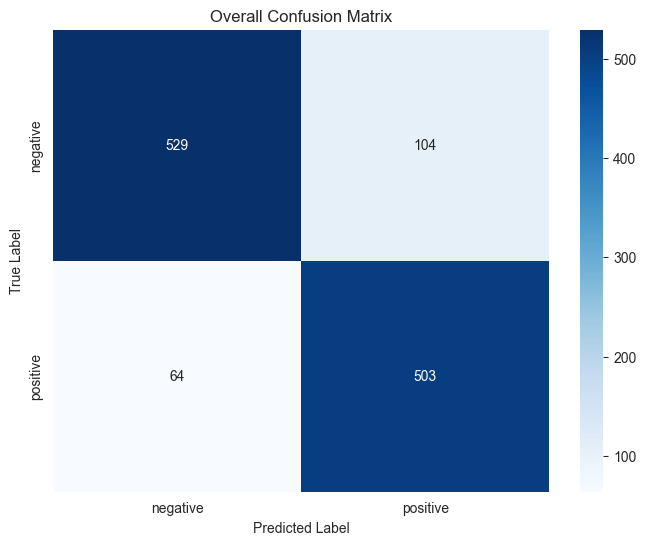

I am very happy with this restaurant!
1/1 [==============================] - 0s 40ms/step
The sentiment of the text is positive
It's so terrible to learn that the plant was late.
1/1 [==============================] - 0s 40ms/step
The sentiment of the text is negative


In [8]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

embed_dim = 128
lstm_out = 196
batch_size = 32


# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold


X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Re-compile the model with L2 regularization
model = Sequential()
# model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))  # Add L2 regularization to the LSTM layer
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I am very happy with this restaurant!"
negative_text = "It's so terrible to learn that the plant was late."
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

150/150 - 50s - loss: 0.5610 - accuracy: 0.7029 - val_loss: 0.3980 - val_accuracy: 0.8325 - 50s/epoch - 332ms/step\
Epoch 2/50\
150/150 - 48s - loss: 0.3309 - accuracy: 0.8683 - val_loss: 0.3454 - val_accuracy: 0.8667 - 48s/epoch - 318ms/step\
Epoch 3/50\
150/150 - 59s - loss: 0.2714 - accuracy: 0.8942 - val_loss: 0.3329 - val_accuracy: 0.8783 - 59s/epoch - 391ms/step\
Epoch 4/50\
150/150 - 60s - loss: 0.2354 - accuracy: 0.9106 - val_loss: 0.3654 - val_accuracy: 0.8533 - 60s/epoch - 402ms/step\
Epoch 5/50\
150/150 - 58s - loss: 0.2214 - accuracy: 0.9175 - val_loss: 0.3675 - val_accuracy: 0.8625 - 58s/epoch - 388ms/step\
Epoch 6/50\
150/150 - 60s - loss: 0.1754 - accuracy: 0.9398 - val_loss: 0.3952 - val_accuracy: 0.8575 - 60s/epoch - 400ms/step\
38/38 - 2s - loss: 0.3952 - accuracy: 0.8575 - 2s/epoch - 53ms/step\
38/38 [==============================] - 2s 46ms/step\
Average score: 0.39521169662475586\
Average accuracy: 0.8575000166893005\
Confusion Matrix (Fold 1):
$$\begin{matrix}
536&97\\
74&493\\
\end{matrix}$$

Classification Report (Fold 1):
               
               precision    recall  f1-score   support

     negative       0.88      0.85      0.86       633
     positive       0.84      0.87      0.85       567

     accuracy                       0.86      1200
    macro avg       0.86      0.86      0.86      1200
    weighted avg     0.86      0.86      0.86      1200

 Overall Confusion Matrix:
$$\begin{matrix}
536&97\\
74&493\\
\end{matrix}$$

Overall Classification Report:

               precision    recall  f1-score   support

     negative       0.88      0.85      0.86       633
     positive       0.84      0.87      0.85       567

     accuracy                       0.86      1200
    macro avg       0.86      0.86      0.86      1200
    weighted avg      0.86      0.86      0.86      1200


This code is Long Short-Term Memory Network (LSTM) model for a sentiment analysis task for two types of emotions. This model is learned on training data and then test data is used to evaluate its performance. The data is first cleaned and preprocessed, then encoded with Keras' Tokenizer and populated with Keras' pad_sequences method.

A deep learning model was created and configured that contained an embedding layer, a bidirectional LSTM layer, and a fully connected layer, and the model used the adam optimizer with a loss function of binary cross-entropy loss.
The model was then trained, and Early Stopping and Model Checkpoint callbacks were used during training.

In this output, we see the results of a model that was trained through 50 training cycles (or epochs), but was actually stopped early after only 6 epochs because from the 4th epoch onwards, the loss in the validation set started to increase, which is a sign of overfitting.

TRAINING RESULTS: After the first epoch, the model's accuracy was 70.29% on the training set and 83.25% on the validation set. As the epoch increases, the accuracy increases on both the training and validation sets, but from the 4th epoch onwards, the loss on the validation set starts to increase, which indicates that the model is starting to overfit.

Performance Metrics: The output shows a variety of performance metrics including precision, recall, and F1 score. Precision is the proportion of samples predicted by the model to be in the positive class (in this case, the 'positive' class) that are actually in the positive class. Recall is the proportion of samples that are actually positive that are predicted to be positive by the model.The F1 score is the harmonic mean of precision and recall, and it balances both as well as possible.

For the 'negative' class, the precision is 0.88, the recall is 0.85, and the F1 score is 0.86. This means that the model predicts the 'negative' class quite well. For the 'positive' class, the precision is 0.84, the recall is 0.87 and the F1 score is 0.85. This is also a good result.

CONFUSION MATRIX: The confusion matrix shows the predictions of the model in each category. Of the 633 samples predicted by the model to be in the 'negative' category, 536 were actually in the 'negative' category and 97 were actually in the 'positive' category. This indicates that the model has some false positives (false positives). Similarly, of the 567 samples predicted by the model to be in the 'positive' category, 493 were actually in the 'positive' category and 74 were actually in the 'negative' category. This indicates that the model also has some underreporting (false negatives).


#### BiLSTM without L2 regularization

Epoch 1/50
150/150 - 60s - loss: 0.5615 - accuracy: 0.7044 - val_loss: 0.3519 - val_accuracy: 0.8608 - 60s/epoch - 401ms/step
Epoch 2/50


D:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 58s - loss: 0.3545 - accuracy: 0.8587 - val_loss: 0.3635 - val_accuracy: 0.8517 - 58s/epoch - 386ms/step
Epoch 3/50
150/150 - 57s - loss: 0.2698 - accuracy: 0.8958 - val_loss: 0.3366 - val_accuracy: 0.8650 - 57s/epoch - 377ms/step
Epoch 4/50
150/150 - 57s - loss: 0.2317 - accuracy: 0.9160 - val_loss: 0.3445 - val_accuracy: 0.8658 - 57s/epoch - 377ms/step
Epoch 5/50
150/150 - 57s - loss: 0.2046 - accuracy: 0.9262 - val_loss: 0.3526 - val_accuracy: 0.8708 - 57s/epoch - 379ms/step
Epoch 6/50
150/150 - 57s - loss: 0.1808 - accuracy: 0.9371 - val_loss: 0.3787 - val_accuracy: 0.8608 - 57s/epoch - 383ms/step
38/38 - 2s - loss: 0.3787 - accuracy: 0.8608 - 2s/epoch - 58ms/step
38/38 [==============================] - 2s 47ms/step
Average score: 0.3786584436893463
Average accuracy: 0.8608333468437195
Confusion Matrix (Fold 1):
[[549  80]
 [ 87 484]]

Classification Report (Fold 1):
              precision    recall  f1-score   support

    negative       0.86      0.87      0.87       

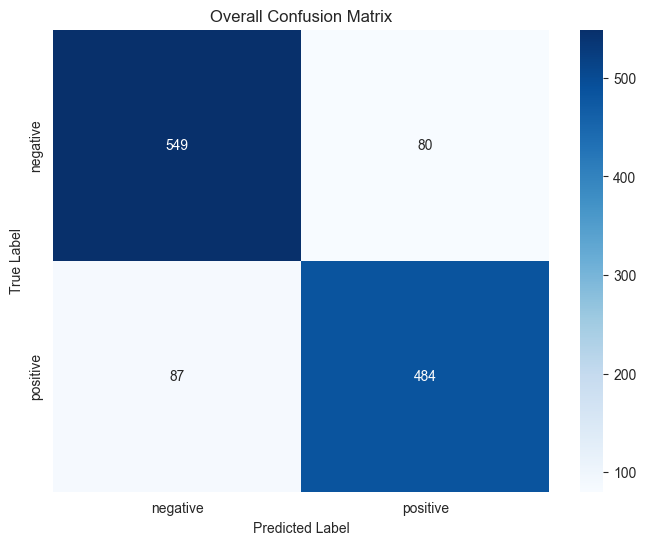

I am very happy with this restaurant!
1/1 [==============================] - 0s 23ms/step
The sentiment of the text is positive
It's so terrible to learn that the plant was late.
1/1 [==============================] - 0s 22ms/step
The sentiment of the text is negative


In [23]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

# Model architecture
embed_dim = 128 # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

# k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


# Re-compile the model with L2 regularization
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))  # Add L2 regularization to the LSTM layer
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I am very happy with this restaurant!"
negative_text = "It's so terrible to learn that the plant was late."
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

150/150 - 53s - loss: 0.5546 - accuracy: 0.7100 - val_loss: 0.3654 - val_accuracy: 0.8450 - 53s/epoch - 350ms/step\
Epoch 2/50\
150/150 - 62s - loss: 0.3357 - accuracy: 0.8673 - val_loss: 0.3536 - val_accuracy: 0.8500 - 62s/epoch - 417ms/step\
Epoch 3/50\
150/150 - 63s - loss: 0.2786 - accuracy: 0.8913 - val_loss: 0.3836 - val_accuracy: 0.8367 - 63s/epoch - 421ms/step\
Epoch 4/50\
150/150 - 63s - loss: 0.2290 - accuracy: 0.9169 - val_loss: 0.3674 - val_accuracy: 0.8558 - 63s/epoch - 420ms/step\
Epoch 5/50\
150/150 - 66s - loss: 0.2011 - accuracy: 0.9277 - val_loss: 0.3771 - val_accuracy: 0.8492 - 66s/epoch - 437ms/step\
38/38 - 2s - loss: 0.3771 - accuracy: 0.8492 - 2s/epoch - 54ms/step
38/38 [==============================] - 2s 48ms/step\
Average score: 0.3771224319934845\
Average accuracy: 0.8491666913032532\
Confusion Matrix (Fold 1):
$$\begin{matrix}
557&87\\
94&462\\
\end{matrix}$$

Classification Report (Fold 1):

               precision    recall  f1-score   support

     negative       0.86      0.86      0.86       644
     positive       0.84      0.83      0.84       556

     accuracy                           0.85      1200
    macro avg       0.85      0.85      0.85      1200
    weighted avg       0.85      0.85      0.85      1200


Overall Confusion Matrix:
$$\begin{matrix}
557&87\\
94&462\\
\end{matrix}$$
Overall Classification Report:


                precision    recall  f1-score   support

     negative       0.86      0.86      0.86       644
     positive       0.84      0.83      0.84       556

     accuracy                           0.85      1200
    macro avg       0.85      0.85      0.85      1200
    weighted avg       0.85      0.85      0.85      1200

Process finished with exit code 0

The above code adds K-fold cross validation to the base bidirectional LSTM model to train the model.

K-fold cross validation is a common method for evaluating the performance of a model, and is especially suitable for situations where the amount of data is small and we want to make the best use of the data possible. In K-folding cross-validation, the dataset is uniformly divided into K subsets. In each iteration, we pick one of these K subsets as the test set and the remaining K-1 subsets as the training set. In this way, we can perform K training and testing sessions, each time with a different test set. We then take the average of the K test results as the final model performance evaluation.

In the code, 5-fold cross-validation is used, which means that the dataset is divided into 5 subsets. This means that your model will be trained 5 times, each time with a different subset of data for training and testing. The benefit of this is that it avoids evaluation bias due to chance in data division and allows for more stable and accurate model evaluation results. The conclusions drawn also show a substantial increase in accuracy compared to not using cross-validation


#### BiLSTM

Epoch 1/50
150/150 - 70s - loss: 1.3077 - accuracy: 0.6690 - val_loss: 0.5603 - val_accuracy: 0.7633 - 70s/epoch - 465ms/step
Epoch 2/50


D:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 67s - loss: 0.4650 - accuracy: 0.8227 - val_loss: 0.5349 - val_accuracy: 0.7750 - 67s/epoch - 447ms/step
Epoch 3/50
150/150 - 67s - loss: 0.3580 - accuracy: 0.8792 - val_loss: 0.4083 - val_accuracy: 0.8542 - 67s/epoch - 449ms/step
Epoch 4/50
150/150 - 68s - loss: 0.2969 - accuracy: 0.9013 - val_loss: 0.3979 - val_accuracy: 0.8400 - 68s/epoch - 452ms/step
Epoch 5/50
150/150 - 71s - loss: 0.2686 - accuracy: 0.9117 - val_loss: 0.3944 - val_accuracy: 0.8608 - 71s/epoch - 470ms/step
Epoch 6/50
150/150 - 71s - loss: 0.3071 - accuracy: 0.9042 - val_loss: 0.4060 - val_accuracy: 0.8550 - 71s/epoch - 472ms/step
Epoch 7/50
150/150 - 68s - loss: 0.2363 - accuracy: 0.9304 - val_loss: 0.4168 - val_accuracy: 0.8475 - 68s/epoch - 455ms/step
Epoch 8/50
150/150 - 69s - loss: 0.2105 - accuracy: 0.9371 - val_loss: 0.4379 - val_accuracy: 0.8492 - 69s/epoch - 458ms/step
38/38 - 3s - loss: 0.4379 - accuracy: 0.8492 - 3s/epoch - 72ms/step
38/38 [==============================] - 3s 79ms/step
Average

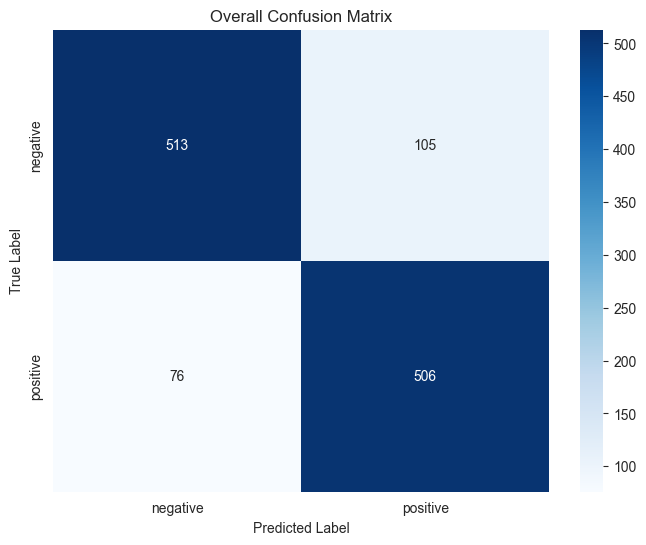

I am very happy with this restaurant!
1/1 [==============================] - 0s 40ms/step
The sentiment of the text is positive
It's so terrible to learn that the plant was late.
1/1 [==============================] - 0s 40ms/step
The sentiment of the text is negative


In [9]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

# Model architecture
embed_dim = 128 # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

# k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


# Re-compile the model with L2 regularization
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))))  # Add L2 regularization to the LSTM layer
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I am very happy with this restaurant!"
negative_text = "It's so terrible to learn that the plant was late."
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

150/150 - 53s - loss: 1.3200 - accuracy: 0.6660 - val_loss: 0.4821 - val_accuracy: 0.8133 - 53s/epoch - 356ms/step\
Epoch 2/50\
150/150 - 63s - loss: 0.4780 - accuracy: 0.8200 - val_loss: 0.4208 - val_accuracy: 0.8492 - 63s/epoch - 422ms/step\
Epoch 3/50\
150/150 - 63s - loss: 0.3440 - accuracy: 0.8823 - val_loss: 0.3597 - val_accuracy: 0.8683 - 63s/epoch - 423ms/step
Epoch 4/50\
150/150 - 63s - loss: 0.2993 - accuracy: 0.8929 - val_loss: 0.3529 - val_accuracy: 0.8683 - 63s/epoch - 417ms/step\
Epoch 5/50\
150/150 - 64s - loss: 0.2750 - accuracy: 0.9073 - val_loss: 0.3640 - val_accuracy: 0.8608 - 64s/epoch - 427ms/step\
Epoch 6/50\
150/150 - 64s - loss: 0.2540 - accuracy: 0.9173 - val_loss: 0.3466 - val_accuracy: 0.8700 - 64s/epoch - 424ms/step\
Epoch 7/50\
150/150 - 63s - loss: 0.2312 - accuracy: 0.9219 - val_loss: 0.3677 - val_accuracy: 0.8650 - 63s/epoch - 421ms/step\
Epoch 8/50\
150/150 - 63s - loss: 0.2146 - accuracy: 0.9312 - val_loss: 0.3816 - val_accuracy: 0.8467 - 63s/epoch - 423ms/step\
Epoch 9/50\
150/150 - 62s - loss: 0.2350 - accuracy: 0.9231 - val_loss: 0.3627 - val_accuracy: 0.8775 - 62s/epoch - 417ms/step\
38/38 - 2s - loss: 0.3627 - accuracy: 0.8775 - 2s/epoch - 56ms/step
38/38 [==============================] - 2s 48ms/step\
Average score: 0.3627375662326813\
Average accuracy: 0.8774999976158142\
Confusion Matrix (Fold 1):
$$\begin{matrix}
567&65\\
82&486\\
\end{matrix}$$

Classification Report (Fold 1):

               precision    recall  f1-score   support

     negative       0.87      0.90      0.89       632
     positive       0.88      0.86      0.87       568

     accuracy                           0.88      1200
    macro avg       0.88      0.88      0.88      1200
    weighted avg      0.88      0.88      0.88      1200
Overall Confusion Matrix:
$$\begin{matrix}
567&65\\
82&486\\
\end{matrix}$$
Overall Classification Report:

               precision    recall  f1-score   support

     negative       0.87      0.90      0.89       632
     positive       0.88      0.86      0.87       568

     accuracy                           0.88      1200
    macro avg       0.88      0.88      0.88      1200
    weighted avg      0.88      0.88      0.88      1200

The L2 regularization method is used in this code, and its kernel_regularizer=l2(0.01) part is where the L2 regularization is applied. l2(0.01) indicates that the L2 regularization function is used and that the value of λ(lambda) is 0.01. The regularization term lambda is a hyperparameter that determines the strength of the regularization. The larger the value of lambda, the greater the degree of regularization and the less likely the model is to overfit. During training, the L2 regularization term (i.e., the sum of the squares of all the weights in the LSTM layer) is computed and then multiplied with the strength of regularization (0.01 in this example). This value is then added to the original loss function of the model. Therefore, it is this new loss function that the model attempts to minimize.
By adding the L2 regularization term, the model is prevented from learning overly complex patterns in the training data.
The L2 regularization in this code helps control the complexity of the model, reduces overfitting, and improves the model's ability to generalize from training data to new, unseen data.
The addition of L2 regularization improves the accuracy of the model as can be seen by comparing Average accuracy to Confusion Matrix

#### CNN BiLSTM

Epoch 1/50
150/150 - 16s - loss: 0.7467 - accuracy: 0.7240 - val_loss: 0.3985 - val_accuracy: 0.8633 - 16s/epoch - 105ms/step
Epoch 2/50


D:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 15s - loss: 0.3155 - accuracy: 0.8829 - val_loss: 0.3807 - val_accuracy: 0.8567 - 15s/epoch - 97ms/step
Epoch 3/50
150/150 - 21s - loss: 0.2355 - accuracy: 0.9181 - val_loss: 0.4235 - val_accuracy: 0.8483 - 21s/epoch - 141ms/step
Epoch 4/50
150/150 - 22s - loss: 0.1949 - accuracy: 0.9312 - val_loss: 0.4583 - val_accuracy: 0.8533 - 22s/epoch - 144ms/step
Epoch 5/50
150/150 - 21s - loss: 0.1606 - accuracy: 0.9481 - val_loss: 0.5362 - val_accuracy: 0.8483 - 21s/epoch - 142ms/step
38/38 - 1s - loss: 0.5362 - accuracy: 0.8483 - 1s/epoch - 26ms/step
38/38 [==============================] - 1s 23ms/step
Average score: 0.5362016558647156
Average accuracy: 0.8483333587646484
Confusion Matrix (Fold 1):
[[539  99]
 [ 83 479]]

Classification Report (Fold 1):
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       638
    positive       0.83      0.85      0.84       562

    accuracy                           0.85      1200
   macro avg  

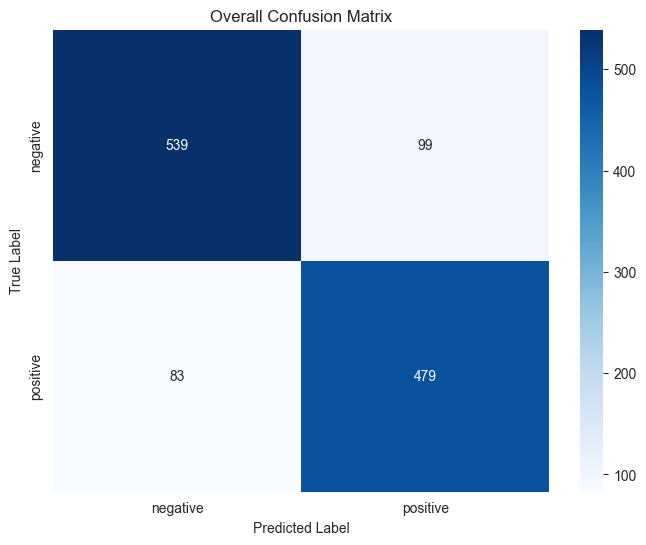

I am very happy with this restaurant!
1/1 [==============================] - 0s 15ms/step
The sentiment of the text is positive
It's so terrible to learn that the plant was late.
1/1 [==============================] - 0s 16ms/step
The sentiment of the text is negative


In [4]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

# Model architecture
embed_dim = 128 # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

# k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I am very happy with this restaurant!"
negative_text = "It's so terrible to learn that the plant was late."
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

Epoch 1/50\
150/150 - 23s - loss: 0.7573 - accuracy: 0.7252 - val_loss: 0.3769 - val_accuracy: 0.8608 - 23s/epoch - 154ms/step\
Epoch 2/50\
150/150 - 23s - loss: 0.3222 - accuracy: 0.8875 - val_loss: 0.3681 - val_accuracy: 0.8617 - 23s/epoch - 152ms/step\
Epoch 3/50\
150/150 - 23s - loss: 0.2567 - accuracy: 0.9133 - val_loss: 0.3591 - val_accuracy: 0.8808 - 23s/epoch - 156ms/step\
Epoch 4/50\
150/150 - 23s - loss: 0.2091 - accuracy: 0.9300 - val_loss: 0.4021 - val_accuracy: 0.8483 - 23s/epoch - 154ms/step\
Epoch 5/50\
150/150 - 23s - loss: 0.1699 - accuracy: 0.9458 - val_loss: 0.4226 - val_accuracy: 0.8675 - 23s/epoch - 154ms/step\
Epoch 6/50\
150/150 - 24s - loss: 0.1340 - accuracy: 0.9590 - val_loss: 0.4389 - val_accuracy: 0.8717 - 24s/epoch - 158ms/step\
38/38 - 1s - loss: 0.4389 - accuracy: 0.8717 - 1s/epoch - 35ms/step\
38/38 [==============================] - 1s 33ms/step\
Average score: 0.4389059543609619\
Average accuracy: 0.871666669845581\

Overall Confusion Matrix:
$$\begin{matrix}
585&73\\
81&461\\
\end{matrix}$$

Overall Classification Report:

                precision    recall  f1-score   support

     negative       0.88      0.89      0.88       658
     positive       0.86      0.85      0.86       542

     accuracy                           0.87      1200
    macro avg       0.87      0.87      0.87      1200
    weighted avg      0.87      0.87      0.87      1200
The above code uses a CNN to extract text features.

filters: 32, which is the number of filters (also known as convolution kernels) used to extract features during the convolution process. In this case, the network will learn 32 different features.

kernel_size: 3, this defines the number of consecutive words that each convolutional kernel will consider simultaneously. Here, each convolution will cover 3 words.

activation: 'relu', this is the activation function applied to the output of the convolution operation. the ReLU (Rectified Linear Unit) function converts all the negative pixel values to 0.
This CNN layer is followed by a MaxPooling layer where the pool_size is set to 2. This means that the input feature dimensions are reduced to half of their original dimensions while maintaining the important information.

The average accuracy of this model is 0.8717. From the confusion matrix, it can be seen that about 89% and 85% of the positive and negative evaluations predicted by the model are correct, respectively.

During the training process, the accuracy and loss values of the model are recorded after each epoch. From the output given, it can be seen that as the epoch increases, the loss value (loss) is decreasing and the accuracy (accuracy) is increasing on the training set. However, on the validation set, the loss value (val_loss) starts increasing after reaching the minimum value and the accuracy (val_accuracy) starts decreasing. This can be a sign of overfitting, indicating that the model overlearned on the training set and does not generalize well to new, unseen data.


### Tri-class Classification

#### BiLSTM without L2 regularization

Epoch 1/25
684/684 - 62s - loss: 0.7726 - accuracy: 0.6524 - val_loss: 0.5543 - val_accuracy: 0.7777 - 62s/epoch - 91ms/step
Epoch 2/25


D:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/684 - 70s - loss: 0.4953 - accuracy: 0.8027 - val_loss: 0.4383 - val_accuracy: 0.8316 - 70s/epoch - 102ms/step
Epoch 3/25
684/684 - 70s - loss: 0.3903 - accuracy: 0.8503 - val_loss: 0.4005 - val_accuracy: 0.8515 - 70s/epoch - 102ms/step
Epoch 4/25
684/684 - 69s - loss: 0.3415 - accuracy: 0.8719 - val_loss: 0.3905 - val_accuracy: 0.8579 - 69s/epoch - 101ms/step
Epoch 5/25
684/684 - 69s - loss: 0.2960 - accuracy: 0.8889 - val_loss: 0.3674 - val_accuracy: 0.8738 - 69s/epoch - 101ms/step
Epoch 6/25
684/684 - 69s - loss: 0.2611 - accuracy: 0.9039 - val_loss: 0.3527 - val_accuracy: 0.8747 - 69s/epoch - 102ms/step
Epoch 7/25
684/684 - 69s - loss: 0.2329 - accuracy: 0.9131 - val_loss: 0.3342 - val_accuracy: 0.8929 - 69s/epoch - 101ms/step
Epoch 8/25
684/684 - 69s - loss: 0.2103 - accuracy: 0.9225 - val_loss: 0.3222 - val_accuracy: 0.9020 - 69s/epoch - 100ms/step
Epoch 9/25
684/684 - 69s - loss: 0.1815 - accuracy: 0.9346 - val_loss: 0.3274 - val_accuracy: 0.9091 - 69s/epoch - 101ms/step
Epo

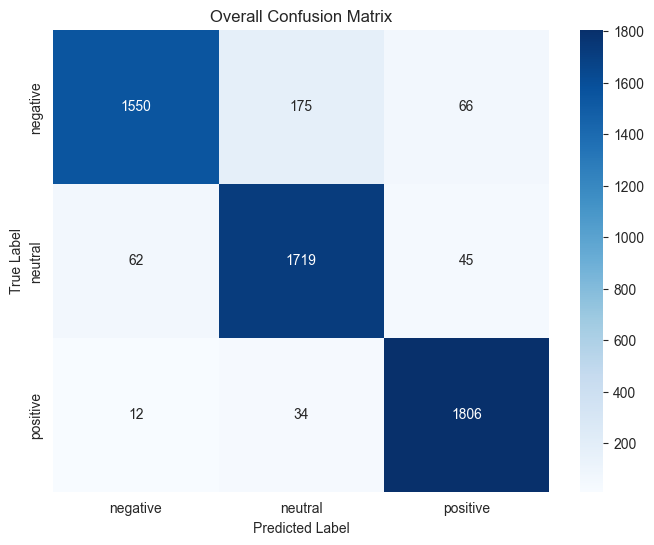

I am very happy with this restaurant!
1/1 [==============================] - 0s 18ms/step
The sentiment of the text is positive
How was your tirp in Sydney?
1/1 [==============================] - 0s 20ms/step
The sentiment of the text is neutral
It's so terrible to learn that the plant was late.
1/1 [==============================] - 0s 19ms/step
The sentiment of the text is negative


In [7]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['airline_sentiment']).values

# Train Word2Vec embeddings
word2vec_embedding_dim = 128 # Set the desired embedding dimension
word2vec_model = Word2Vec(sentences=[text.split() for text in data['text'].values],
                          vector_size=word2vec_embedding_dim, window=3, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((max_features, word2vec_embedding_dim))
for word, i in token.word_index.items():
    if word in word2vec_model.wv and i < max_features:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture
embed_dim = word2vec_embedding_dim # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)


# Re-compile the model with L2 regularization
model = Sequential()
model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))  # Add L2 regularization to the LSTM layer
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I am very happy with this restaurant!"
neutral_text = "How was your tirp in Sydney?"
negative_text = "It's so terrible to learn that the plant was late."
print(positive_text)
predict_sentiment(positive_text)
print(neutral_text)
predict_sentiment(neutral_text)
print(negative_text)
predict_sentiment(negative_text)

684/684 - 37s - loss: 0.7659 - accuracy: 0.6597 - val_loss: 0.5798 - val_accuracy: 0.7588 - 37s/epoch - 54ms/step\
Epoch 2/25\
684/684 - 35s - loss: 0.5300 - accuracy: 0.7858 - val_loss: 0.4678 - val_accuracy: 0.8150 - 35s/epoch - 52ms/step\
Epoch 3/25\
684/684 - 36s - loss: 0.4155 - accuracy: 0.8362 - val_loss: 0.3927 - val_accuracy: 0.8523 - 36s/epoch - 52ms/step\
Epoch 4/25\
684/684 - 36s - loss: 0.3484 - accuracy: 0.8655 - val_loss: 0.3607 - val_accuracy: 0.8658 - 36s/epoch - 53ms/step\
Epoch 5/25\
684/684 - 37s - loss: 0.3009 - accuracy: 0.8854 - val_loss: 0.3453 - val_accuracy: 0.8751 - 37s/epoch - 55ms/step\
Epoch 6/25\
684/684 - 36s - loss: 0.2587 - accuracy: 0.9040 - val_loss: 0.3194 - val_accuracy: 0.8885 - 36s/epoch - 53ms/step\
Epoch 7/25\
684/684 - 38s - loss: 0.2292 - accuracy: 0.9164 - val_loss: 0.3176 - val_accuracy: 0.9002 - 38s/epoch - 55ms/step\
Epoch 8/25\
684/684 - 38s - loss: 0.2046 - accuracy: 0.9273 - val_loss: 0.3126 - val_accuracy: 0.9009 - 38s/epoch - 55ms/step\
Epoch 9/25\
684/684 - 38s - loss: 0.1769 - accuracy: 0.9374 - val_loss: 0.2992 - val_accuracy: 0.9100 - 38s/epoch - 55ms/step\
Epoch 10/25\
684/684 - 37s - loss: 0.1574 - accuracy: 0.9440 - val_loss: 0.2728 - val_accuracy: 0.9206 - 37s/epoch - 54ms/step\
Epoch 11/25\
684/684 - 37s - loss: 0.1404 - accuracy: 0.9518 - val_loss: 0.2943 - val_accuracy: 0.9210 - 37s/epoch - 54ms/step\
Epoch 12/25\
684/684 - 38s - loss: 0.1222 - accuracy: 0.9564 - val_loss: 0.2930 - val_accuracy: 0.9210 - 38s/epoch - 55ms/step\
Epoch 13/25\
684/684 - 37s - loss: 0.1120 - accuracy: 0.9605 - val_loss: 0.2929 - val_accuracy: 0.9278 - 37s/epoch - 54ms/step\
171/171 - 3s - loss: 0.2929 - accuracy: 0.9278 - 3s/epoch - 20ms/step\
171/171 [==============================] - 2s 13ms/step\
Average score: 0.29285070300102234\
Average accuracy: 0.9277747273445129\

Overall Confusion Matrix:
$$\begin{matrix}
1526&181&84\\
46&1745&35\\
23&26&1803\\
\end{matrix}$$
Overall Classification Report:

                precision    recall  f1-score   support

     negative       0.96      0.85      0.90      1791
      neutral       0.89      0.96      0.92      1826
     positive       0.94      0.97      0.96      1852

     accuracy                       0.93      5469
    macro avg       0.93      0.93      0.93      5469
    weighted avg       0.93      0.93      0.93      5469
1/1 [==============================] - 0s 11ms/step
The sentiment of the text is positive

The overall and binary when the data is processed in a similar way, this model uses more pre-trained word embeddings (GloVe), and it can be seen that the increase in dimensionality increases the amount of data at the same time, and the accuracy of the model is much higher than the same processing of two-dimensional data.

#### BiLSTM

Epoch 1/50
684/684 - 82s - loss: 1.1233 - accuracy: 0.6108 - val_loss: 0.7439 - val_accuracy: 0.7129 - 82s/epoch - 120ms/step
Epoch 2/50


D:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/684 - 78s - loss: 0.6573 - accuracy: 0.7584 - val_loss: 0.5756 - val_accuracy: 0.8011 - 78s/epoch - 114ms/step
Epoch 3/50
684/684 - 78s - loss: 0.5353 - accuracy: 0.8176 - val_loss: 0.5204 - val_accuracy: 0.8186 - 78s/epoch - 114ms/step
Epoch 4/50
684/684 - 77s - loss: 0.4823 - accuracy: 0.8373 - val_loss: 0.4920 - val_accuracy: 0.8309 - 77s/epoch - 113ms/step
Epoch 5/50
684/684 - 77s - loss: 0.4508 - accuracy: 0.8459 - val_loss: 0.4756 - val_accuracy: 0.8365 - 77s/epoch - 113ms/step
Epoch 6/50
684/684 - 77s - loss: 0.4257 - accuracy: 0.8590 - val_loss: 0.4565 - val_accuracy: 0.8448 - 77s/epoch - 113ms/step
Epoch 7/50
684/684 - 77s - loss: 0.4029 - accuracy: 0.8655 - val_loss: 0.4617 - val_accuracy: 0.8459 - 77s/epoch - 113ms/step
Epoch 8/50
684/684 - 78s - loss: 0.3928 - accuracy: 0.8687 - val_loss: 0.4377 - val_accuracy: 0.8598 - 78s/epoch - 114ms/step
Epoch 9/50
684/684 - 77s - loss: 0.3776 - accuracy: 0.8758 - val_loss: 0.4375 - val_accuracy: 0.8517 - 77s/epoch - 112ms/step
Epo

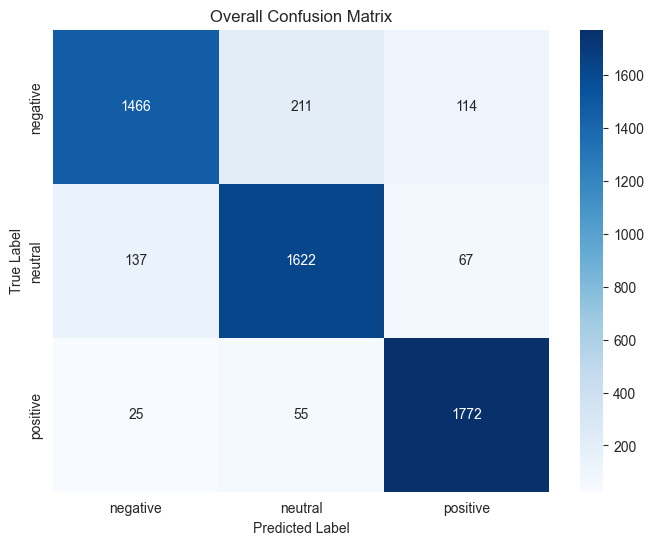

I am very happy with this restaurant!
1/1 [==============================] - 0s 21ms/step
The sentiment of the text is positive
How was your tirp in Sydney?
1/1 [==============================] - 0s 20ms/step
The sentiment of the text is neutral
It's so terrible to learn that the plant was late.
1/1 [==============================] - 0s 20ms/step
The sentiment of the text is negative


In [8]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['airline_sentiment']).values

# Train Word2Vec embeddings
word2vec_embedding_dim = 128 # Set the desired embedding dimension
word2vec_model = Word2Vec(sentences=[text.split() for text in data['text'].values],
                          vector_size=word2vec_embedding_dim, window=3, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((max_features, word2vec_embedding_dim))
for word, i in token.word_index.items():
    if word in word2vec_model.wv and i < max_features:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture
embed_dim = word2vec_embedding_dim # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32


# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Re-compile the model with L2 regularization
model = Sequential()
model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))))  # Add L2 regularization to the LSTM layer
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I am very happy with this restaurant!"
neutral_text = "How was your tirp in Sydney?"
negative_text = "It's so terrible to learn that the plant was late."
print(positive_text)
predict_sentiment(positive_text)
print(neutral_text)
predict_sentiment(neutral_text)
print(negative_text)
predict_sentiment(negative_text)

S684/684 - 38s - loss: 1.0973 - accuracy: 0.6288 - val_loss: 0.7020 - val_accuracy: 0.7407 - 38s/epoch - 55ms/step\
Epoch 2/50\
684/684 - 36s - loss: 0.6880 - accuracy: 0.7463 - val_loss: 0.6039 - val_accuracy: 0.7822 - 36s/epoch - 53ms/step\
Epoch 3/50\
684/684 - 37s - loss: 0.5793 - accuracy: 0.7966 - val_loss: 0.5351 - val_accuracy: 0.8133 - 37s/epoch - 55ms/step\
Epoch 4/50\
684/684 - 38s - loss: 0.5123 - accuracy: 0.8270 - val_loss: 0.4918 - val_accuracy: 0.8320 - 38s/epoch - 55ms/step\
Epoch 5/50\
684/684 - 38s - loss: 0.4701 - accuracy: 0.8438 - val_loss: 0.4784 - val_accuracy: 0.8431 - 38s/epoch - 56ms/step\
Epoch 6/50\
684/684 - 38s - loss: 0.4420 - accuracy: 0.8542 - val_loss: 0.4722 - val_accuracy: 0.8406 - 38s/epoch - 55ms/step\
Epoch 7/50\
684/684 - 37s - loss: 0.4234 - accuracy: 0.8590 - val_loss: 0.4439 - val_accuracy: 0.8513 - 37s/epoch - 54ms/step\
Epoch 8/50\
684/684 - 37s - loss: 0.4010 - accuracy: 0.8697 - val_loss: 0.4442 - val_accuracy: 0.8587 - 37s/epoch - 54ms/step\
Epoch 9/50\
684/684 - 37s - loss: 0.3881 - accuracy: 0.8737 - val_loss: 0.4305 - val_accuracy: 0.8673 - 37s/epoch - 54ms/step\
Epoch 10/50\
684/684 - 37s - loss: 0.3740 - accuracy: 0.8785 - val_loss: 0.4291 - val_accuracy: 0.8663 - 37s/epoch - 54ms/step\
Epoch 11/50\
684/684 - 37s - loss: 0.3589 - accuracy: 0.8868 - val_loss: 0.4230 - val_accuracy: 0.8691 - 37s/epoch - 54ms/step\
Epoch 12/50\
684/684 - 37s - loss: 0.3495 - accuracy: 0.8894 - val_loss: 0.4136 - val_accuracy: 0.8724 - 37s/epoch - 54ms/step\
Epoch 13/50\
684/684 - 36s - loss: 0.3410 - accuracy: 0.8918 - val_loss: 0.4144 - val_accuracy: 0.8738 - 36s/epoch - 53ms/step\
Epoch 14/50\
684/684 - 36s - loss: 0.3292 - accuracy: 0.8961 - val_loss: 0.4088 - val_accuracy: 0.8758 - 36s/epoch - 53ms/step\
Epoch 15/50\
684/684 - 36s - loss: 0.3234 - accuracy: 0.8987 - val_loss: 0.4132 - val_accuracy: 0.8762 - 36s/epoch - 53ms/step\
Epoch 16/50\
684/684 - 36s - loss: 0.3148 - accuracy: 0.9041 - val_loss: 0.4190 - val_accuracy: 0.8726 - 36s/epoch - 53ms/step\
Epoch 17/50\
684/684 - 37s - loss: 0.3040 - accuracy: 0.9086 - val_loss: 0.3950 - val_accuracy: 0.8854 - 37s/epoch - 54ms/step\
Epoch 18/50\
684/684 - 37s - loss: 0.2990 - accuracy: 0.9115 - val_loss: 0.3971 - val_accuracy: 0.8857 - 37s/epoch - 54ms/step\
Epoch 19/50\
684/684 - 37s - loss: 0.2933 - accuracy: 0.9127 - val_loss: 0.3916 - val_accuracy: 0.8850 - 37s/epoch - 54ms/step\
Epoch 20/50\
684/684 - 37s - loss: 0.2897 - accuracy: 0.9132 - val_loss: 0.3922 - val_accuracy: 0.8874 - 37s/epoch - 54ms/step\
Epoch 21/50\
684/684 - 37s - loss: 0.2826 - accuracy: 0.9148 - val_loss: 0.3805 - val_accuracy: 0.8897 - 37s/epoch - 55ms/step\
Epoch 22/50\
684/684 - 37s - loss: 0.2812 - accuracy: 0.9160 - val_loss: 0.3985 - val_accuracy: 0.8854 - 37s/epoch - 55ms/step\
Epoch 23/50\
684/684 - 37s - loss: 0.2711 - accuracy: 0.9222 - val_loss: 0.4051 - val_accuracy: 0.8879 - 37s/epoch - 55ms/step\
Epoch 24/50\
684/684 - 38s - loss: 0.2687 - accuracy: 0.9216 - val_loss: 0.3831 - val_accuracy: 0.8929 - 38s/epoch - 55ms/step\
171/171 - 4s - loss: 0.3831 - accuracy: 0.8929 - 4s/epoch - 23ms/step\
171/171 [==============================] - 3s 18ms/step\
Average score: 0.38307949900627136\
Average accuracy: 0.8928506374359131

Overall Confusion Matrix:
$$\begin{matrix}
1484&217&90\\
112&1643&71\\
38&58&1756\\
\end{matrix}$$
Overall Classification Report:

                precision    recall  f1-score   support

     negative      0.91      0.83      0.87      1791   
     neutral       0.86      0.90      0.88      1826
     positive       0.92      0.95      0.93      1852

     accuracy                       0.89      5469
    macro avg       0.89      0.89      0.89      5469
    weighted avg       0.89      0.89      0.89      5469

Cross-validation resulted in less data in the training phase, making the performance slightly degraded because the model complexity was not high and the l2 regularization was too strong already resulting in a negative fit.

#### CNN BiLSTM

Epoch 1/50
684/684 - 17s - loss: 0.6968 - accuracy: 0.6990 - val_loss: 0.5582 - val_accuracy: 0.7623 - 17s/epoch - 25ms/step
Epoch 2/50


D:\python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/684 - 14s - loss: 0.4390 - accuracy: 0.8289 - val_loss: 0.4035 - val_accuracy: 0.8460 - 14s/epoch - 20ms/step
Epoch 3/50
684/684 - 14s - loss: 0.3332 - accuracy: 0.8747 - val_loss: 0.3392 - val_accuracy: 0.8793 - 14s/epoch - 20ms/step
Epoch 4/50
684/684 - 13s - loss: 0.2662 - accuracy: 0.9026 - val_loss: 0.3045 - val_accuracy: 0.8987 - 13s/epoch - 20ms/step
Epoch 5/50
684/684 - 13s - loss: 0.2182 - accuracy: 0.9224 - val_loss: 0.3422 - val_accuracy: 0.8896 - 13s/epoch - 19ms/step
Epoch 6/50
684/684 - 13s - loss: 0.1807 - accuracy: 0.9367 - val_loss: 0.3597 - val_accuracy: 0.8916 - 13s/epoch - 19ms/step
Epoch 7/50
684/684 - 13s - loss: 0.1537 - accuracy: 0.9479 - val_loss: 0.3121 - val_accuracy: 0.9036 - 13s/epoch - 19ms/step
171/171 - 1s - loss: 0.3121 - accuracy: 0.9036 - 787ms/epoch - 5ms/step
171/171 [==============================] - 1s 5ms/step
Average score: 0.31214988231658936
Average accuracy: 0.9036387205123901
Confusion Matrix (Fold 1):
[[1634  108   49]
 [ 241 1547   38]

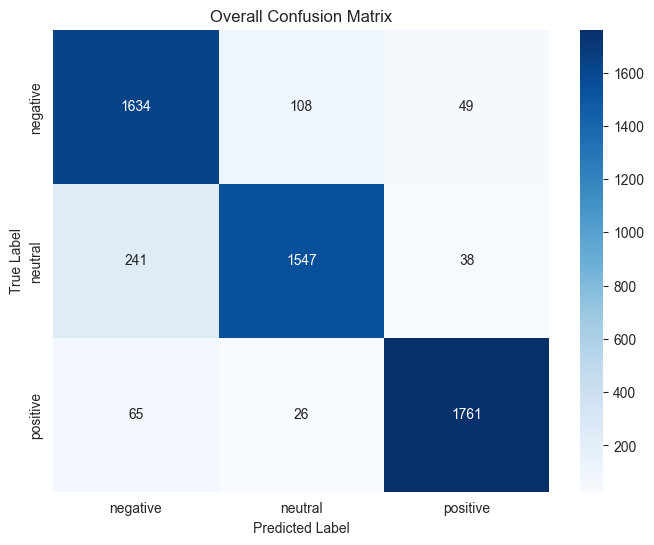

I am very happy with this restaurant!
1/1 [==============================] - 0s 12ms/step
The sentiment of the text is positive
How was your tirp in Sydney?
1/1 [==============================] - 0s 11ms/step
The sentiment of the text is neutral
It's so terrible to learn that the plant was late.
1/1 [==============================] - 0s 11ms/step
The sentiment of the text is negative


In [4]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['airline_sentiment']).values

# Train Word2Vec embeddings
word2vec_embedding_dim = 128 # Set the desired embedding dimension
word2vec_model = Word2Vec(sentences=[text.split() for text in data['text'].values],
                          vector_size=word2vec_embedding_dim, window=3, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((max_features, word2vec_embedding_dim))
for word, i in token.word_index.items():
    if word in word2vec_model.wv and i < max_features:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture
embed_dim = word2vec_embedding_dim # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32


# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I am very happy with this restaurant!"
neutral_text = "How was your tirp in Sydney?"
negative_text = "It's so terrible to learn that the plant was late."
print(positive_text)
predict_sentiment(positive_text)
print(neutral_text)
predict_sentiment(neutral_text)
print(negative_text)
predict_sentiment(negative_text)

684/684 - 17s - loss: 0.6827 - accuracy: 0.7053 - val_loss: 0.5152 - val_accuracy: 0.7936 - 17s/epoch - 25ms/step\
Epoch 2/50\
684/684 - 12s - loss: 0.4330 - accuracy: 0.8333 - val_loss: 0.4159 - val_accuracy: 0.8440 - 12s/epoch - 18ms/step\
Epoch 3/50\
684/684 - 12s - loss: 0.3278 - accuracy: 0.8798 - val_loss: 0.3470 - val_accuracy: 0.8733 - 12s/epoch - 18ms/step\
Epoch 4/50\
684/684 - 13s - loss: 0.2643 - accuracy: 0.9063 - val_loss: 0.3238 - val_accuracy: 0.8908 - 13s/epoch - 19ms/step\
Epoch 5/50\
684/684 - 13s - loss: 0.2175 - accuracy: 0.9256 - val_loss: 0.3285 - val_accuracy: 0.8855 - 13s/epoch - 20ms/step\
Epoch 6/50\
684/684 - 14s - loss: 0.1791 - accuracy: 0.9382 - val_loss: 0.2970 - val_accuracy: 0.9091 - 14s/epoch - 20ms/step\
Epoch 7/50\
684/684 - 13s - loss: 0.1412 - accuracy: 0.9536 - val_loss: 0.3187 - val_accuracy: 0.9120 - 13s/epoch - 20ms/step\
Epoch 8/50\
684/684 - 13s - loss: 0.1217 - accuracy: 0.9598 - val_loss: 0.2913 - val_accuracy: 0.9168 - 13s/epoch - 20ms/step\
Epoch 9/50\
684/684 - 13s - loss: 0.1016 - accuracy: 0.9679 - val_loss: 0.3333 - val_accuracy: 0.9106 - 13s/epoch - 19ms/step\
Epoch 10/50\
684/684 - 13s - loss: 0.0875 - accuracy: 0.9709 - val_loss: 0.2742 - val_accuracy: 0.9360 - 13s/epoch - 19ms/step\
Epoch 11/50\
684/684 - 14s - loss: 0.0785 - accuracy: 0.9756 - val_loss: 0.3300 - val_accuracy: 0.9181 - 14s/epoch - 20ms/step\
Epoch 12/50\
684/684 - 14s - loss: 0.0656 - accuracy: 0.9795 - val_loss: 0.3010 - val_accuracy: 0.9283 - 14s/epoch - 20ms/step\
Epoch 13/50\
684/684 - 14s - loss: 0.0599 - accuracy: 0.9806 - val_loss: 0.3859 - val_accuracy: 0.9195 - 14s/epoch - 21ms/step\
171/171 - 1s - loss: 0.3859 - accuracy: 0.9195 - 923ms/epoch - 5ms/step\
171/171 [==============================] - 1s 4ms/step\
Average score: 0.3859206736087799\
Average accuracy: 0.9195465445518494\
 Overall Confusion Matrix:
$$\begin{matrix}
1453&256&82\\
33&1754&39\\
17&13&1822\\
\end{matrix}$$

Overall Classification Report:

                precision    recall  f1-score   support

     negative       0.97      0.81      0.88      1791
      neutral       0.87      0.96      0.91      1826
     positive       0.94      0.98      0.96      1852

     accuracy                       0.92      5469
    macro avg       0.92      0.92      0.92      5469
    weighted avg       0.92      0.92      0.92      5469

It is clear that the cnn model is faster and equally accurate
(0.920)

Analysis:
1. After vector transformation, cnn is better at handling locally correlated data than bi, which requires global dependencies.
2. all computations in cnn are parallel, each convolutional kernel can be computed on all inputs at the same time.

The computation of each time step in bi depends on the hidden state of the previous time step, so it must be computed in a sequence of time steps.



### Conclusion

This comparative analysis of ML and DL methods reveals compelling insights for sentiment analysis on both binary and tri-class datasets.

1. CNN Outperforms: The results demonstrate that CNN consistently exhibits higher accuracy compared to SVM and BiLSTM for both binary and tri-class sentiment data. Revealed the superior capability of CNN in capturing essential features from the text, leading to more precise sentiment predictions.

2. Optimal Use of BiLSTM and Cross-Validation: When dealing with small sample sizes of data, incorporating cross-validation proves beneficial for BiLSTM, especially in binary data scenarios. However, for large datasets, cross-validation may adversely impact accuracy due to data duplication during training, leading to increased computational demands and longer processing times.

3. Overfitting Mitigation with L2 Regularization: The usage of L2 regularization in BiLSTM effectively tackles overfitting concerns. Additionally, early stopping proves to be a valuable technique in minimizing overfitting to a certain extent.

4. BiLSTM with CNN: The BiLSTM combined with CNN emerges as the most promising training model. This architecture not only delivers impressive speed but also maximizes the extraction of crucial data features. The synergistic combination of BiLSTM and CNN contributes to overall superior performance in sentiment analysis tasks.